## 1.0 Environment & Data Ingestion

This section documents the configuration of the forensic environment and the ingestion of the Sparkov-generated dataset (Kartik2112). The objective is to establish a verified data baseline for fraud analysis.

In [37]:
### 1.1 Configuration & Library Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import xgboost
import imblearn
import joblib
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 120
sns.set_style('whitegrid')

print('All libraries imported successfully.')

All libraries imported successfully.


In [38]:
### 1.2 Data Ingestion & Schema Validation

train_df = pd.read_csv('data/raw/fraudTrain.csv')
test_df = pd.read_csv('data/raw/fraudTest.csv')

print('Training data shape:', train_df.shape)
print('Test data shape:', test_df.shape)
print()
train_df.head(3)

Training data shape: (1296675, 23)
Test data shape: (555719, 23)



,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0


## 2.0 Data Integrity & Initial Transformation

We perform a standard integrity audit to verify data completeness and class balance before engineering forensic features.

In [39]:
### 2.1 Missing Value & Duplicate Audit

missing_count = train_df.isnull().sum().sum()
duplicate_count = train_df.duplicated().sum()

print(f'Missing Values: {missing_count}')
print(f'Duplicate Rows: {duplicate_count}')

# Class balance
fraud_ratio = train_df['is_fraud'].mean() * 100
fraud_count = train_df['is_fraud'].sum()
legit_count = len(train_df) - fraud_count
print(f'\nClass Balance:')
print(f'  Legitimate (0): {legit_count:,} ({100 - fraud_ratio:.2f}%)')
print(f'  Fraud (1):      {fraud_count:,} ({fraud_ratio:.2f}%)')
print(f'  Imbalance ratio: 1:{legit_count / fraud_count:.1f} (fraud:legitimate)')

if missing_count == 0 and duplicate_count == 0:
    print('\nData Integrity Confirmed: No anomalies detected.')

Missing Values: 0
Duplicate Rows: 0

Class Balance:
  Legitimate (0): 1,289,169 (99.42%)
  Fraud (1):      7,506 (0.58%)
  Imbalance ratio: 1:171.8 (fraud:legitimate)

Data Integrity Confirmed: No anomalies detected.


In [40]:
### 2.2 Temporal & Demographic Feature Derivation

# Convert datetime columns
train_df['trans_date_trans_time'] = pd.to_datetime(train_df['trans_date_trans_time'])
train_df['dob'] = pd.to_datetime(train_df['dob'])

# Calculate age from transaction date and date of birth
train_df['age'] = (train_df['trans_date_trans_time'] - train_df['dob']).dt.days // 365

# Extract hour of day
train_df['hour'] = train_df['trans_date_trans_time'].dt.hour

# Create age group bins
train_df['age_group'] = pd.cut(
    train_df['age'],
    bins=[0, 30, 50, 70, 120],
    labels=['<30', '30-50', '50-70', '70+']
)

print('Derived Features: Age, Hour, Age_Group created.')

Derived Features: Age, Hour, Age_Group created.


## 3.0 EDA: The 4-Pillar Investigation

A forensic exploratory analysis focusing on the "When, Who, How, and Where" of the adversarial behavior.

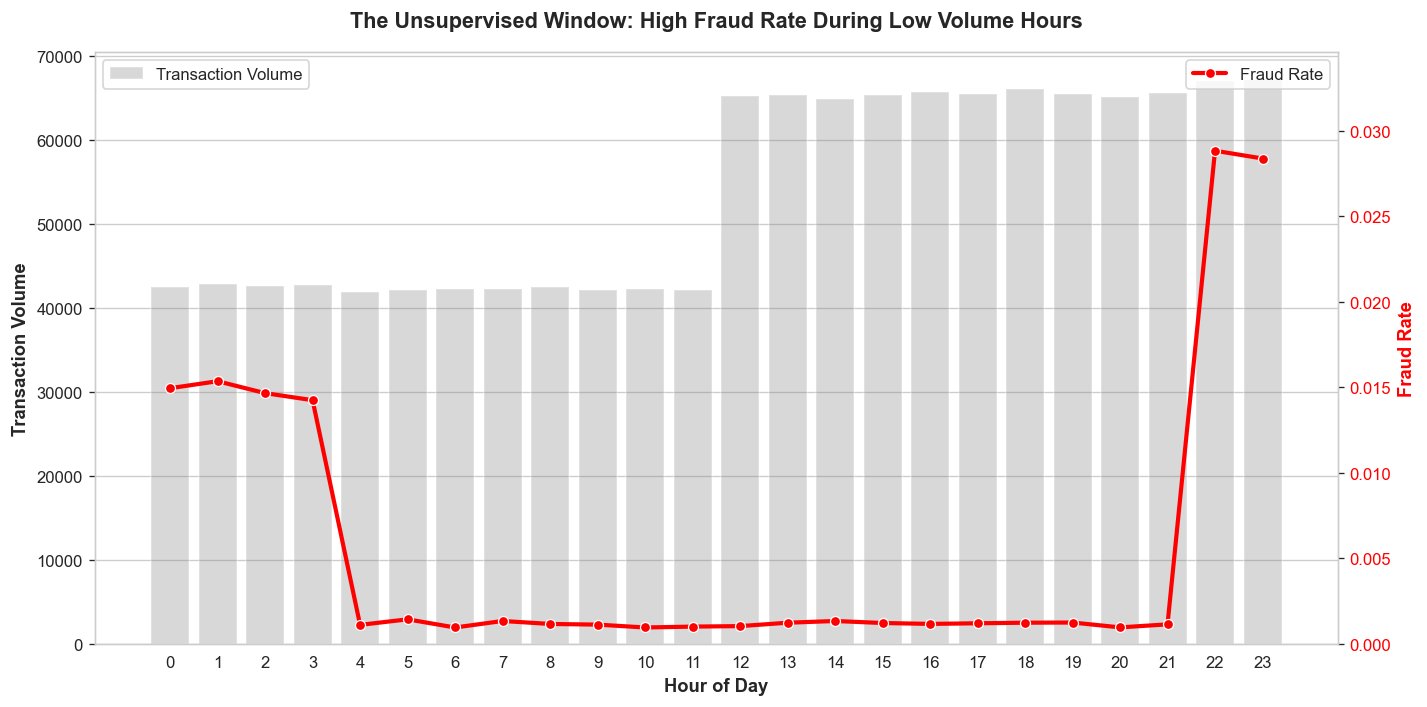

Peak fraud rate: Hour 22 (2.883%)
Peak transaction volume: Hour 23 (67,104 transactions)

Inverse relationship confirmed: High fraud rate during low volume hours.


In [41]:
### 3.1 THE WHEN: Temporal Signatures

hourly_stats = train_df.groupby('hour').agg(
    volume=('trans_num', 'count'),
    fraud_rate=('is_fraud', 'mean')
)

fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary axis: transaction volume (grey bars)
sns.barplot(
    x=hourly_stats.index, y=hourly_stats['volume'],
    alpha=0.3, color='grey', ax=ax1, label='Transaction Volume'
)
ax1.set_ylabel('Transaction Volume', fontsize=11, fontweight='bold')
ax1.set_xlabel('Hour of Day', fontsize=11, fontweight='bold')

# Secondary axis: fraud rate (red line)
ax2 = ax1.twinx()
sns.lineplot(
    x=hourly_stats.index, y=hourly_stats['fraud_rate'],
    color='red', marker='o', ax=ax2, label='Fraud Rate', linewidth=2.5
)
ax2.set_ylabel('Fraud Rate', fontsize=11, fontweight='bold', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, hourly_stats['fraud_rate'].max() * 1.2)

plt.title(
    'The Unsupervised Window: High Fraud Rate During Low Volume Hours',
    fontsize=13, fontweight='bold', pad=15
)
plt.grid(False)
fig.tight_layout()
plt.show()

peak_fraud_hour = hourly_stats['fraud_rate'].idxmax()
peak_volume_hour = hourly_stats['volume'].idxmax()
print(f'Peak fraud rate: Hour {peak_fraud_hour} ({hourly_stats.loc[peak_fraud_hour, "fraud_rate"]:.3%})')
print(f'Peak transaction volume: Hour {peak_volume_hour} ({hourly_stats.loc[peak_volume_hour, "volume"]:,} transactions)')
print(f'\nInverse relationship confirmed: High fraud rate during low volume hours.')

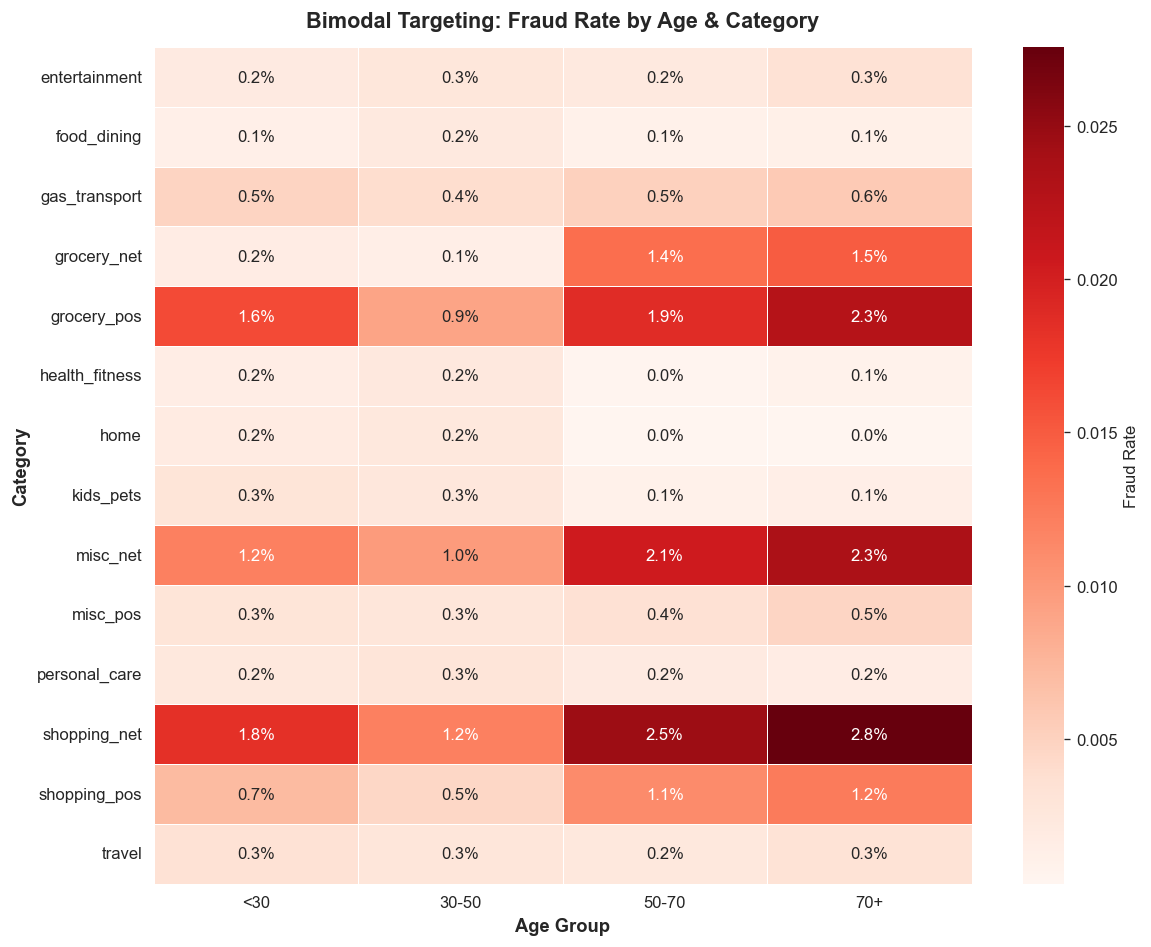

Top 10 Highest-Risk Age-Category Combinations:
  1. shopping_net (70+): 2.76%
  2. shopping_net (50-70): 2.45%
  3. misc_net (70+): 2.35%
  4. grocery_pos (70+): 2.27%
  5. misc_net (50-70): 2.05%
  6. grocery_pos (50-70): 1.88%
  7. shopping_net (<30): 1.83%
  8. grocery_pos (<30): 1.63%
  9. grocery_net (70+): 1.50%
  10. grocery_net (50-70): 1.35%


In [42]:
### 3.2 THE WHO: Demographic Vulnerability

age_cat_risk = train_df.pivot_table(
    index='category', columns='age_group',
    values='is_fraud', aggfunc='mean'
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    age_cat_risk, cmap='Reds', annot=True, fmt='.1%',
    cbar_kws={'label': 'Fraud Rate'}, linewidths=0.5
)
plt.title(
    'Bimodal Targeting: Fraud Rate by Age & Category',
    fontsize=13, fontweight='bold', pad=12
)
plt.xlabel('Age Group', fontsize=11, fontweight='bold')
plt.ylabel('Category', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

# Print highest-risk combinations
print('Top 10 Highest-Risk Age-Category Combinations:')
age_cat_flat = age_cat_risk.stack().sort_values(ascending=False)
for idx, (cat_age, rate) in enumerate(age_cat_flat.head(10).items(), 1):
    print(f'  {idx}. {cat_age[0]} ({cat_age[1]}): {rate:.2%}')

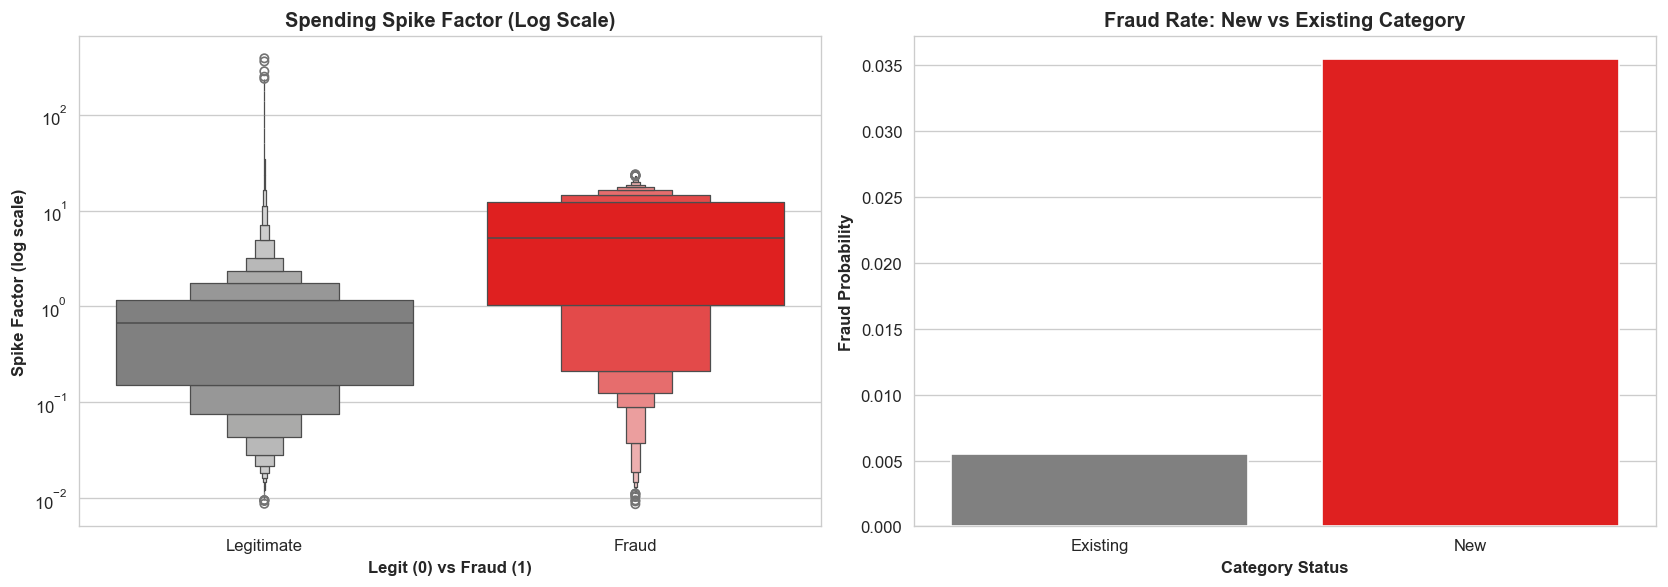

Spending Spike Analysis:
  Median spike (Legitimate): 0.67x
  Median spike (Fraud):      5.18x

Category Shift Analysis:
  Fraud rate (Existing category): 0.5486%
  Fraud rate (New category):      3.5452%
  Risk multiplier: 6.46x


In [43]:
### 3.3 THE HOW: Behavioral Displacement

# Spending spike factor: transaction amount relative to cardholder average
train_df['avg_card_amt'] = train_df.groupby('cc_num')['amt'].transform('mean')
train_df['spike_factor'] = train_df['amt'] / train_df['avg_card_amt']

# Category shift: flag first-time category usage per cardholder
train_df = train_df.sort_values(['cc_num', 'trans_date_trans_time'])
train_df['cat_cumcount'] = train_df.groupby(['cc_num', 'category']).cumcount()
train_df['is_new_category'] = train_df['cat_cumcount'] == 0

# Side-by-side visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Spending Spike (Boxenplot, Log Scale)
sns.boxenplot(
    data=train_df, x='is_fraud', y='spike_factor',
    ax=axes[0], palette=['grey', 'red']
)
axes[0].set_yscale('log')
axes[0].set_title('Spending Spike Factor (Log Scale)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Legit (0) vs Fraud (1)', fontsize=10, fontweight='bold')
axes[0].set_ylabel('Spike Factor (log scale)', fontsize=10, fontweight='bold')
axes[0].set_xticklabels(['Legitimate', 'Fraud'])

# Right: Category Shift (Barplot)
category_fraud_rate = train_df.groupby('is_new_category')['is_fraud'].mean()
sns.barplot(
    x=[False, True], y=category_fraud_rate.values,
    ax=axes[1], palette=['grey', 'red']
)
axes[1].set_title('Fraud Rate: New vs Existing Category', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Category Status', fontsize=10, fontweight='bold')
axes[1].set_ylabel('Fraud Probability', fontsize=10, fontweight='bold')
axes[1].set_xticklabels(['Existing', 'New'])

plt.tight_layout()
plt.show()

# Print statistics
print('Spending Spike Analysis:')
print(f'  Median spike (Legitimate): {train_df[train_df["is_fraud"] == 0]["spike_factor"].median():.2f}x')
print(f'  Median spike (Fraud):      {train_df[train_df["is_fraud"] == 1]["spike_factor"].median():.2f}x')
print(f'\nCategory Shift Analysis:')
print(f'  Fraud rate (Existing category): {category_fraud_rate[False]:.4%}')
print(f'  Fraud rate (New category):      {category_fraud_rate[True]:.4%}')
print(f'  Risk multiplier: {category_fraud_rate[True] / category_fraud_rate[False]:.2f}x')

### 3.4 THE WHERE: Geospatial Assessment

**Forensic Audit Note:**

A detailed audit in [`geospatial_neutrality_report.ipynb`](geospatial_neutrality_report.ipynb) confirms that geospatial features (coordinates, state, city_pop) are **statistically neutral** in this dataset:

- **State Targeting:** r ≈ 1.0 — fraud is uniformly distributed across all states.
- **Velocity:** Zero recall on travelers with impossible speeds (>100 km/h) — the attack vector is digital/remote.
- **Population Density:** No distinction between urban and rural targeting — distributions overlap completely.

**Decision:** Geospatial features are excluded from the primary modeling pipeline to prevent noise injection. The model will focus exclusively on behavioral and temporal signals that demonstrate discriminatory power in this synthetic dataset.